# Emerging Technologies
---

## Introduction

--- 

In [1]:
# Standard library.
# Combinatorial tools (e.g., Cartesian product).
import itertools

# Third-party libraries.
# Plotting and visualization.
import matplotlib.pyplot as plt
# Numerical arrays and random number generation.
import numpy as np
# DataFrames for tabular data display.
import pandas as pd
# Quantum circuit construction.
from qiskit import QuantumCircuit

## Problem 1: Generating Random Boolean Functions
>The Deutsch–Jozsa algorithm is designed to work with functions that accept a fixed number of Boolean inputs and return a single Boolean output. Each function is guaranteed to be either constant (always returns False or always returns True) or balanced (returns True for exactly half of the possible input combinations). Write a Python function random_constant_balanced that returns a randomly chosen function from the set of constant or balanced functions taking four Boolean arguments as inputs.

The Deutsch-Jozsa algorithm, proposed by David Deutsch and Richard Jozsa in their [1992 paper](https://doi.org/10.1098/rspa.1992.0167), was one of the first examples demonstrating a quantum algorithm's exponential speedup over any deterministic classical algorithm. The problem involves a black-box function (an "oracle"), $f$, which takes an $n$-bit binary string as input and returns a single bit:

$$
f: \{0,1\}^n \rightarrow \{0,1\}
$$

The problem guarantees (promises) that $f$ belongs to one of two strictly defined categories:

- **Constant**: The output is the same (0 or 1) for all possible input strings.
- **Balanced**: The output is 0 for exactly half of the inputs and 1 for the other half.

See [this IBM course section](https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/quantum-query-algorithms/deutsch-jozsa-algorithm) for a more detailed overview of the Deutsch-Jozsa algorithm.

### Scale of the Problem

For this problem, we are simulating an oracle with $n=4$ bits. This creates an input space of size $N = 2^4 = 16$. There are only **2 constant functions** (all-`True` or all-`False`), but the number of possible balanced functions is given by the [binomial coefficient](https://mathworld.wolfram.com/BinomialCoefficient.html):

$$
\binom{16}{8} = 12{,}870
$$

This means we are randomly sampling from a pool of 12,872 total valid functions. The enormous imbalance between 2 constant and 12,870 balanced functions illustrates why a purely random Boolean function is overwhelmingly likely to be balanced. However, to effectively test the algorithm's ability to distinguish between these categories, our implementation artificially forces a 50% probability of selecting either category first, ensuring our test suite remains rigorous for both cases.

### Implementation Approach

A standard approach for simulating classical oracles is to pre-compute a [truth table](https://www.techtarget.com/whatis/definition/truth-table) and wrap it in a callable function, as described in introductory quantum computing resources such as [IBMs Quantum courses](https://quantum.cloud.ibm.com/learning/en/courses). The function below uses this approach:

- **Randomly Selects the Type**: Uses a uniform random choice to decide if the function is constant or balanced.
- **Constructs the Truth Table**:
    - Constant: An array of size 16 filled with all `False` or all `True`.
    - Balanced: An array containing eight `False` and eight `True` values, which is then shuffled using [`numpy.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html).
- **Encapsulates Logic**: The function returns a callable oracle object using a [closure](https://www.geeksforgeeks.org/python/python-closures/). This object maps the 4 input bits $(a, b, c, d)$ to an integer index (0-15) to retrieve the pre-calculated output, effectively hiding the internal state from the user.

In [2]:
def random_constant_balanced():
    """
    Generate a random constant or balanced Boolean function.
    
    Returns a function f(a, b, c, d) that takes four Boolean arguments
    and returns a Boolean output. The function is guaranteed to be either:
    - Constant: returns the same value for all 16 possible inputs
    - Balanced: returns True for exactly 8 inputs, False for 8 inputs
    
    The returned function has a .type attribute ('Constant' or 'Balanced')
    for verification purposes only.
    
    Returns:
        callable: A function taking four Boolean arguments.
    """
    # Number of Boolean inputs for the oracle.
    num_bits = 4
    # Total number of possible input combinations (2^4 = 16).
    num_inputs = 2 ** num_bits

    # Randomly choose between constant and balanced (50/50).
    is_constant = np.random.randint(0, 2)
    
    if is_constant:
        # Randomly pick True or False as the constant output.
        constant_value = bool(np.random.randint(0, 2))
        # Fill the entire truth table with this single value.
        outputs = np.full(num_inputs, constant_value, dtype=bool)
        function_type = "Constant"
    else:
        # Balanced: exactly half True, half False.
        outputs = np.array(
            [False] * (num_inputs // 2)
            + [True] * (num_inputs // 2)
        )
        # Shuffle to randomize which inputs map to True vs False.
        np.random.shuffle(outputs)
        function_type = "Balanced"

    def oracle(a, b, c, d):
        """
        Evaluate the oracle function.
        
        Maps 4 Boolean arguments to an integer index using binary 
        weighting (8, 4, 2, 1), then uses the pre-computed outputs 
        array as a lookup table.

        Args:
            a (bool): First input bit.
            b (bool): Second input bit.
            c (bool): Third input bit.
            d (bool): Fourth input bit.

        Returns:
            bool: The output of the oracle function for the given inputs.
        """
        # Convert Boolean inputs to an integer index (0-15).
        index = 8 * int(a) + 4 * int(b) + 2 * int(c) + int(d)
        # Look up the pre-computed result in the truth table.
        return outputs[index]
    
    # Attach the function type for verification purposes.
    oracle.type = function_type
    return oracle

The key line inside the oracle is the index calculation using binary weighting:

```python
index = 8*int(a) + 4*int(b) + 2*int(c) + int(d)
```

Each Boolean input is treated as a binary digit with positional weights $2^3, 2^2, 2^1, 2^0$ (i.e. 8, 4, 2, 1). This converts the 4-bit input into a unique integer from 0 to 15, which is then used to look up the pre-computed output in the truth table. For example, the input `(True, False, True, False)` maps to $8(1) + 4(0) + 2(1) + 0 = 10$, so the oracle returns `outputs[10]`.

In [3]:
# Demonstrating the binary weighting index calculation.
example_input = (True, False, True, False)

# Unpack the tuple into individual Boolean variables.
a, b, c, d = example_input

# Calculate the index using binary positional weights.
index = 8 * int(a) + 4 * int(b) + 2 * int(c) + int(d)

# Display the calculation step by step.
print(f"Input: {example_input}")
print(
    f"Index: 8*{int(a)} + 4*{int(b)}"
    f" + 2*{int(c)} + {int(d)} = {index}"
)

Input: (True, False, True, False)
Index: 8*1 + 4*0 + 2*1 + 0 = 10


### Testing the Oracle

To ensure the above function works correctly, we need to verify that every function it creates follows the **Deutsch-Jozsa promise**. This means every function must be either 100% constant or exactly 50/50 balanced.

Since we are using 4 Boolean inputs, there are $2^4 = 16$ possible combinations. The code cell below uses [`itertools.product`](https://docs.python.org/3/library/itertools.html#itertools.product) to generate the full input space, then passes it to a test function that evaluates the oracle on every combination:

1. **Generates all 16 possible inputs**: Using `itertools.product`, it covers every combination from `(False, False, False, False)` to `(True, True, True, True)`.
2. **Runs the oracle**: The test function executes the oracle for every single combination.
3. **Counts the distribution**: It counts how many times the function returns `True` versus `False`.

A **PASS** is confirmed if:
* **Constant** functions return `True` either 0 times or 16 times.
* **Balanced** functions return `True` exactly 8 times.

In [4]:
def test_random_constant_balanced(oracle_func, input_space):
    """
    Checks the oracle across all 16 inputs to verify the 
    Constant or Balanced distribution.
    
    Args:
        oracle_func: The function to test (must have .type attribute).
        input_space: List of all possible input tuples.
        
    Prints:
        PASS/FAIL status with distribution counts.
    """
    # Evaluate the oracle for every input combination.
    results = [
        oracle_func(*input_tuple)
        for input_tuple in input_space
    ]
    
    # Count how many results are True.
    true_count = sum(results)
    # The remainder must be False.
    false_count = len(input_space) - true_count
    
    # Check if the distribution matches the oracle's declared type.
    if oracle_func.type == "Constant":
        # Constant: must be all True (16) or all False (0).
        is_valid = (true_count == 0 or true_count == 16)
    else:
        # Balanced: must have exactly 8 True values.
        is_valid = (true_count == 8)
    
    # Print the verification result.
    status = "PASS" if is_valid else "FAIL"
    print(
        f"Result: {status} - Type: {oracle_func.type} - "
        f"True: {true_count}, False: {false_count}"
    )

In [5]:
# Generate all 16 possible 4-bit Boolean combinations.
# itertools.product creates the Cartesian product of [False, True]
# repeated 4 times, covering (F,F,F,F) through (T,T,T,T).
# See: https://docs.python.org/3/library/itertools.html#itertools.product
bit_combinations = list(
    itertools.product([False, True], repeat=4)
)

# Run verification on 10 randomly generated oracles.
for _ in range(10):
    current_oracle = random_constant_balanced()
    test_random_constant_balanced(current_oracle, bit_combinations)

Result: PASS - Type: Constant - True: 16, False: 0
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Constant - True: 16, False: 0
Result: PASS - Type: Constant - True: 0, False: 16
Result: PASS - Type: Constant - True: 16, False: 0
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Balanced - True: 8, False: 8
Result: PASS - Type: Balanced - True: 8, False: 8


All 10 randomly generated oracles pass verification, confirming that `random_constant_balanced` correctly upholds the Deutsch-Jozsa promise. Every constant oracle produced outputs that were entirely `True` or entirely `False`, and every balanced oracle returned `True` for exactly 8 of the 16 inputs. This gives us confidence that the function can be used as a reliable oracle generator for the remaining problems.

### Visualizing the Oracles

To confirm the internal logic of the generated oracles, we can inspect them both numerically and visually. This approach ensures that the "Black Box" functions adhere strictly to the **Deutsch-Jozsa Promise** by utilizing tools from the standard data science stack, specifically [`pandas`](https://pandas.pydata.org/docs/) and [`matplotlib`](https://matplotlib.org/stable/index.html).

The following section generates one sample of each oracle type to display their raw truth tables and digital "signatures." The constant oracle should produce a flat line (all outputs identical), while the balanced oracle should show a mix of `True` and `False` values — visually confirming the structural difference between the two types.

In [6]:
def get_representative_samples():
    """
    Generate one Constant and one Balanced oracle for demonstration.
    
    Repeatedly calls random_constant_balanced() until at least one
    of each type has been obtained.
    
    Returns:
        tuple: A (constant_oracle, balanced_oracle) pair.
    """
    constant_sample = None
    balanced_sample = None
    
    # Keep generating until we have one of each type.
    while constant_sample is None or balanced_sample is None:
        new_oracle = random_constant_balanced()
        
        # Store the oracle in the appropriate slot.
        if new_oracle.type == "Constant":
            constant_sample = new_oracle
        else:
            balanced_sample = new_oracle
            
    return constant_sample, balanced_sample

In [7]:
# Generate one constant and one balanced oracle for comparison.
oracle_c, oracle_b = get_representative_samples()

# Build a DataFrame with all 16 input combinations as columns A-D.
df_viz = pd.DataFrame(
    bit_combinations, columns=['A', 'B', 'C', 'D']
)

# Evaluate each oracle across all inputs and store the results.
# The * operator unpacks each row tuple into the oracle's arguments.
df_viz['Constant Oracle'] = [
    oracle_c(*row) for row in bit_combinations
]
df_viz['Balanced Oracle'] = [
    oracle_b(*row) for row in bit_combinations
]

# Display the complete truth table for both oracle types.
display(df_viz)

,A,B,C,D,Constant Oracle,Balanced Oracle
0,False,False,False,False,True,True
1,False,False,False,True,True,False
2,False,False,True,False,True,False
3,False,False,True,True,True,False
4,False,True,False,False,True,False
5,False,True,False,True,True,True
6,False,True,True,False,True,False
7,False,True,True,True,True,True
8,True,False,False,False,True,False
9,True,False,False,True,True,True


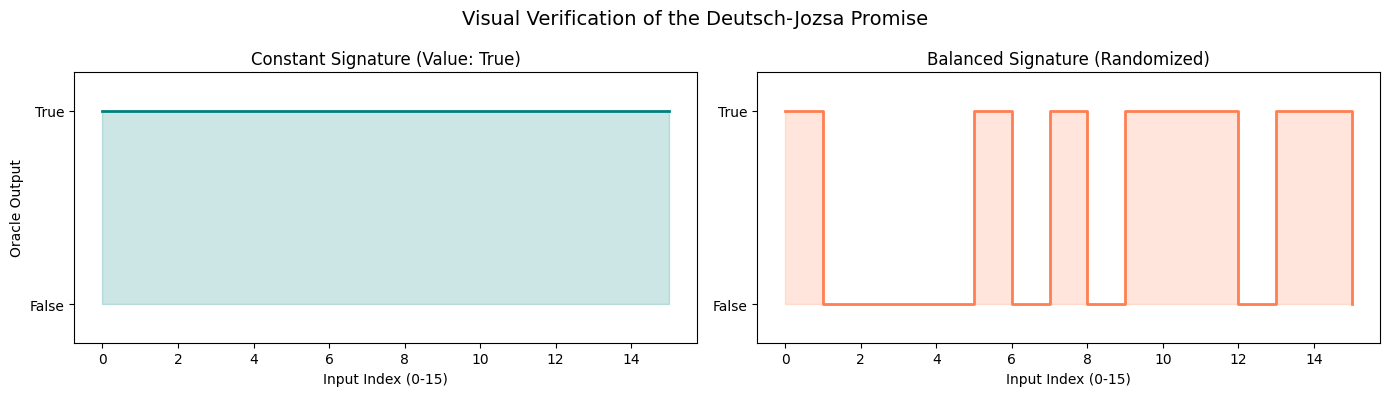

In [8]:
# Create a side-by-side figure for comparing oracle signatures.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Extract the oracle outputs as integers for plotting.
constant_outputs = df_viz['Constant Oracle'].astype(int)
balanced_outputs = df_viz['Balanced Oracle'].astype(int)

# Plot the constant oracle using a step plot.
# Step plots suit the discrete binary nature of the outputs.
ax1.step(
    range(16), constant_outputs,
    where='post', color='teal', linewidth=2
)
# Add a shaded region under the curve for visual clarity.
ax1.fill_between(
    range(16), constant_outputs,
    step="post", alpha=0.2, color='teal'
)
ax1.set_title(
    f"Constant Signature (Value: {df_viz['Constant Oracle'][0]})"
)

# Plot the balanced oracle using the same step plot style.
ax2.step(
    range(16), balanced_outputs,
    where='post', color='coral', linewidth=2
)
ax2.fill_between(
    range(16), balanced_outputs,
    step="post", alpha=0.2, color='coral'
)
ax2.set_title("Balanced Signature (Randomized)")

# Standardize both axes for consistent Boolean comparison.
for ax in [ax1, ax2]:
    ax.set_ylim(-0.2, 1.2)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['False', 'True'])
    ax.set_xlabel("Input Index (0-15)")

# Label the y-axis and add a main title.
ax1.set_ylabel("Oracle Output")
plt.suptitle(
    "Visual Verification of the Deutsch-Jozsa Promise",
    fontsize=14
)
plt.tight_layout()
plt.show()

The plots above visually confirm the difference between the two oracle types. The constant oracle produces a completely flat line — every input maps to the same output value. The balanced oracle, by contrast, shows a randomized pattern of highs and lows, with exactly 8 of each. This visual "signature" makes the distinction between the two types immediately obvious to a human observer, but as we will see in Problem 2, a classical algorithm cannot always determine the type so easily — it may need up to 9 queries in the worst case.

---
## Problem 2: Classical Testing for Function Type
>Deutsch's algorithm is designed to demonstrate a potential advantage of quantum computing over classical computation. To understand this advantage, we must first understand the classical cost of solving the underlying problem. Write a Python function determine_constant_balanced that takes as input a function f, as defined in Problem 1. The function should analyze f and return the string "constant" or "balanced" depending on whether the function is constant or balanced. Write a brief note on the efficiency of your solution. What is the maximum number of times you need to call f to be 100% certain whether it is constant or balanced?

In Problem 1, we built a generator for constant and balanced oracle functions. The next step is to determine an oracle's type *without* knowing the answer in advance. Classically, this means querying the function with different inputs and analyzing the outputs. The key question, as posed by Deutsch and Jozsa in their [original paper](https://doi.org/10.1098/rspa.1992.0167), is: how many queries does a classical algorithm need to be **100% certain**?

### The Early Exit Strategy

The approach I have taken is an "early exit" strategy. Rather than evaluating all 16 inputs, the algorithm stops as soon as it has gathered enough evidence to reach a definitive conclusion:

- If **any two queries** return different values, the function must be **balanced** (a constant function would return the same value for every input).
- If **enough consecutive queries** all return the same value, the function must be **constant**.

### Worst-Case Query Complexity

The critical question is: how many identical results do we need before we can rule out a balanced function? This is answered by the [pigeonhole principle](https://www.geeksforgeeks.org/engineering-mathematics/discrete-mathematics-the-pigeonhole-principle/). A balanced function over 16 inputs returns `True` for exactly 8 inputs and `False` for 8 inputs. In the worst case, we might query all 8 inputs that share the same output value before encountering the other. Therefore:

$$
N_{max} = \frac{2^n}{2} + 1 = 2^{n-1} + 1 = 2^{4-1} + 1 = 9
$$

- After **8 identical results**: the function *could* still be balanced (we might have seen all 8 instances of one value, with the other 8 remaining).
- After **9 identical results**: the function *must* be constant, since a balanced function only has 8 of each value.

This $O(2^{n-1})$ worst case is the classical baseline that the Deutsch-Jozsa algorithm improves upon. 

### Best Case

If the first two queries return different values, we immediately know the function is balanced, requiring only **2 queries**. This is the best-case scenario and occurs whenever the first two inputs happen to map to different outputs.

### Classical vs Quantum

This 9-query worst case establishes the classical baseline. The Deutsch-Jozsa quantum algorithm, which we will explore in the following problems, requires only **1 query** regardless of input size — an exponential improvement that demonstrates a concrete advantage of quantum computation.

In [9]:
def determine_constant_balanced(f):
    """
    Determines whether the given function f is Constant or Balanced.
    
    Uses early termination: stops as soon as it has enough evidence to be 
    100% certain, demonstrating the efficiency limit of classical search.

    Args:
        f (callable): A function that takes four Boolean arguments and 
                      returns a Boolean.
                      
    Returns:
        tuple: A tuple containing:
            - str: "Constant" or "Balanced" based on the analysis of f
            - int: The number of queries made to reach the conclusion
    """
    # bit_combinations defined in Problem 1
    inputs = bit_combinations
    
    # Query the first input
    first_output = f(*inputs[0])
    query_count = 1
    
    # Query remaining inputs (start from the second input)
    for bit_pattern in inputs[1:]:
        current_result = f(*bit_pattern)
        query_count += 1
        
        # If find a different value, definitely Balanced
        if current_result != first_output:
            return "Balanced", query_count
        
        # If 9 identical results, definitely Constant
        # (Balanced functions have exactly 8 of each value)
        if query_count == 9:
            return "Constant", query_count
    
    # All 16 inputs gave the same result, then Constant
    return "Constant", query_count 

### Testing the Classifier

To verify the accuracy and efficiency of the `determine_constant_balanced` function, the test loop below generates 10 random oracles using `random_constant_balanced` from Problem 1. Each oracle's `.type` attribute provides the ground truth, allowing us to check both:

- **Functional Verification**: Does the predicted type match the actual type?
- **Efficiency Observation**: How many queries were needed? Constant functions should consistently require 9 queries (worst case), while balanced functions should be identified much faster (often just 2-3 queries).

In [10]:
print(f"{'Actual Type':<15} | {'Predicted':<15} | {'Queries':<10} | {'PASS/FAIL'}")
print("-" * 60)

all_correct = True
for _ in range(10):
    test_oracle = random_constant_balanced()
    prediction, count = determine_constant_balanced(test_oracle)
    
    is_correct = (test_oracle.type == prediction)
    all_correct = all_correct and is_correct
    
    status = "PASS" if is_correct else "FAIL"
    print(f"{test_oracle.type:<15} | {prediction:<15} | {count:<10} | {status}")

print("\n" + ("All tests passed" if all_correct else "Some tests failed"))

Actual Type     | Predicted       | Queries    | PASS/FAIL
------------------------------------------------------------
Constant        | Constant        | 9          | PASS
Constant        | Constant        | 9          | PASS
Balanced        | Balanced        | 4          | PASS
Constant        | Constant        | 9          | PASS
Balanced        | Balanced        | 3          | PASS
Balanced        | Balanced        | 5          | PASS
Balanced        | Balanced        | 6          | PASS
Balanced        | Balanced        | 2          | PASS
Constant        | Constant        | 9          | PASS
Balanced        | Balanced        | 5          | PASS

All tests passed


The results confirm that `determine_constant_balanced` correctly identifies every oracle's type. As expected, constant functions always require the full 9 queries — the algorithm cannot rule out a balanced function until the 9th identical result. Balanced functions, on the other hand, are identified in as few as 2 queries, since the algorithm exits immediately upon finding two different output values. This demonstrates the efficiency gap between the best and worst cases and motivates the quantum approach explored in the following problems, where a single query suffices regardless of the function type.

---
## Problem 3: Quantum Oracles
>Deutsch's algorithm is the simplest example of a quantum algorithm using superposition to determine a global property of a function with a single evaluation. In the single-input case, there are four possible Boolean functions. Using Qiskit, create the appropriate quantum oracles for each of the possible single-Boolean-input functions used in Deutsch's algorithm. Demonstrate their use and explain how each oracle implements its corresponding function.

---
## Problem 4: Deutsch's Algorithm with Qiskit
>Use Qiskit to design a quantum circuit that solves Deutsch's problem for a function with a single Boolean input. Implement the necessary circuit and demonstrate its use with each of the quantum oracles from Problem 3. Describe how the interference pattern produced by the circuit allows you to determine whether the function is constant or balanced using only one query to the oracle.

---
## Problem 5: Scaling to the Deutsch–Jozsa Algorithm
>The Deutsch–Jozsa algorithm generalizes Deutsch's approach to functions with several input bits. Use Qiskit to create a quantum circuit that can handle the four-bit functions generated in Problem 1. Explain how the classical function is encoded as a quantum oracle, and demonstrate the use of your circuit on both of the constant functions and any two balanced functions of your choosing. Show that the circuit correctly identifies the type of each function.

---
## Conclusion

---
# End